In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%autosave 0

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

import warnings
#suppress all future warning
warnings.filterwarnings('ignore')

Autosave disabled


In [2]:
df = pd.read_csv('US_Accidents_March23.csv',index_col=0, parse_dates=True)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

In [3]:
df.shape

(7728394, 45)

In [4]:
df.columns.values

array(['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country',
       'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'], dtype=object)

In [5]:
df.reset_index(inplace=True)

### Cleaning the dataSet

Dropping the below columns as some of those('ID','Source','Airport_Code','Sunrise_Sunset','End_Lat','End_Lng','Description') are unrelated, some ('Turning_Loop','Country') have only one unique value and 'Weather_Timestamp' has very similar time as "Start_Time".

In [6]:
df.head()

ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0      39.87     -84.06      NaN      NaN          0.01  ...      False   
1      39.93     -82.83      NaN      NaN          0.01  ...      False   
2      39.06     -84.03      NaN      NaN          0.01  ...      False   
3      39.75     -84.21      NaN      NaN          0.01  ...      False   
4      39.63     -84.19      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          False        False          Night   
1   False  False           False          False        False          Night   
2   False  False           False           True        False          Night   
3   False  False           False          False        False          Night   
4   False  False           False           True        False            Day   

  Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0          Night             Night                 Night  
1          Night             Night                   Day  
2          Night               Day                   Day  
3            Day               Day                   Day  
4            Day               Day                   Day  

[5 rows x 46 columns]

In [7]:
df.replace(to_replace=['?',' '],value=np.nan,inplace=True)

In [8]:
df.drop(columns=['ID','Description', 'Wind_Direction', 'End_Lng', 'End_Lat', 'Weather_Timestamp',\
                 'Country', 'Source', 'County', 'ID', 'Airport_Code'],inplace=True)

In [9]:
df.drop_duplicates(inplace=True)

Renaming the columns to perform calculations (Removing brackets from the column names)

In [10]:
df.rename(columns={'Distance':'Distance','Precipitation(in)':'Precipitation','Temperature(F)':'Temperature','Wind_Chill(F)':'Wind_Chill',\
                  'Humidity(%)':'Humidity','Pressure(in)':'Pressure','Visibility(mi)':'Visibility',\
                   'Wind_Speed(mph)':'Wind_Speed'},inplace=True)

Dropping NaNs from the columns with insignificant number of NaNs.

In [11]:
df.dropna(how='any',subset=['City'],inplace=True)
df.dropna(how='any',subset=['Street'],inplace=True)
df.dropna(how='any',subset=['Zipcode'],inplace=True)
df.dropna(how='any',subset=['Timezone'],inplace=True)
df.dropna(how='any',subset=['Civil_Twilight'],inplace=True)
df.dropna(how='any',subset=['Astronomical_Twilight'],inplace=True)
df.dropna(how='any',subset=['Nautical_Twilight'],inplace=True)

Filling in NaN's with the mean and median values of the respective columns as the NaNs in these columns are significant in number.

In [12]:
df['Temperature'].fillna(df['Temperature'].mean(), inplace=True)
df['Wind_Chill'].fillna(df['Wind_Chill'].mean(), inplace=True)
df['Humidity'].fillna(df['Humidity'].mean(), inplace=True)
df['Pressure'].fillna(df['Pressure'].mean(), inplace=True)
df['Visibility'].fillna(df['Visibility'].median(), inplace=True)
df['Wind_Speed'].fillna(df['Wind_Speed'].median(), inplace=True)
df['Precipitation'].fillna(df['Precipitation'].median(), inplace=True)

Filling in NaN's with forward filling method

In [13]:
df['Weather_Condition'].fillna(method='ffill',inplace=True)

In [14]:
df.isna().sum().sum()

0

In [15]:
df.shape

(7566065, 36)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

severity_counts = df['Severity'].value_counts()
severity_counts


# Most accidents are of severity '2' and '3', 
# with very few cases of severity '1' and '4'.

2    6011746
3    1291377
4     197935
1      65007
Name: Severity, dtype: int64

Text(0.5, 1.0, 'Distribution of Accident Severity')

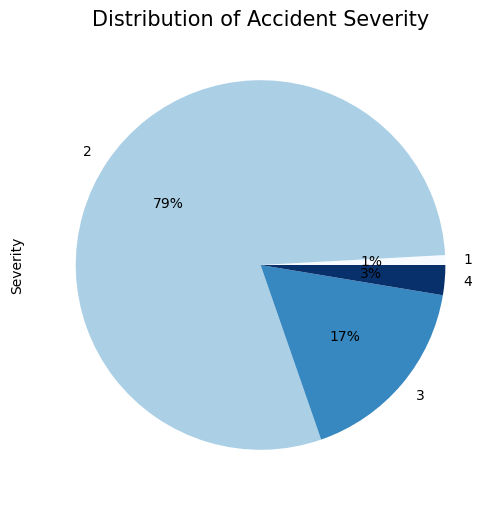

In [17]:
pie_chart = df.groupby('Severity')['Severity'].count().\
            plot(kind='pie',figsize=(6, 6),autopct='%1.0f%%',cmap="Blues")

labels = severity_counts.index.tolist()
# Adding a title to the pie chart
pie_chart.set_title('Distribution of Accident Severity', fontsize=15)


Miami          183485
Houston        168242
Los Angeles    154732
Charlotte      136731
Dallas         129743
Orlando        108517
Austin          96411
Raleigh         85057
Nashville       72210
Baton Rouge     70682
Name: City, dtype: int64

<Axes: >

Text(0.5, 1.0, 'Top 10 Cities with Most Accidents')

Text(0.5, 0, 'Number of Accidents')

Text(0, 0.5, 'City')

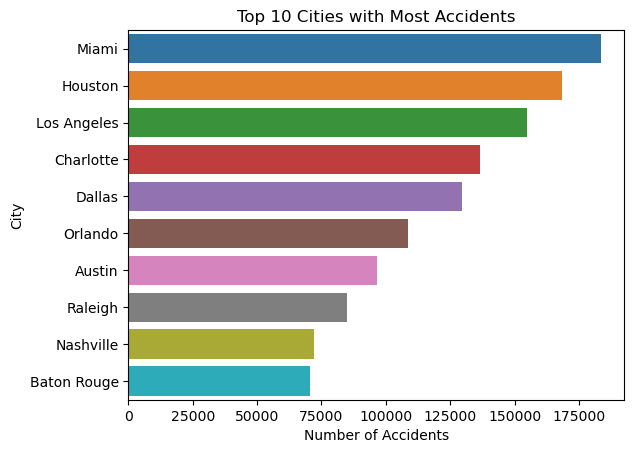

In [18]:
# 5. Traffic Management and Infrastructure Improvement
# Analyzing accidents based on city or county
citywise_accidents = df['City'].value_counts().head(10)  # Top 10 cities
citywise_accidents
# Citywise distribution plot
sns.barplot(y=citywise_accidents.index, x=citywise_accidents.values)
plt.title('Top 10 Cities with Most Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('City')
# plt.text(1, max(citywise_accidents.values) * 1, 'Miami and LA identify areas with high accident frequencies to improve road safety measures', fontsize=6, color='black')
plt.show()



Hotspot Analysis: Major citis like Miami, Houston, LA identify areas with high accident frequencies

In [34]:
import plotly.express as px

# Group by 'City' and count the number of accidents
city_accidents = df.groupby('City').size().reset_index(name='Accident_Count')

# 'Start_Lat' and 'Start_Lng' give the coordinates for the accidents
cities_df = df[['City', 'Start_Lat', 'Start_Lng']].drop_duplicates(subset=['City'])

# Merge the city locations with the accident counts
plotting_df = pd.merge(cities_df, city_accidents, on='City')

# Set your Mapbox access token here
px.set_mapbox_access_token('pk.eyJ1IjoiYWppbmt5YWRlc2FpIiwiYSI6ImNscGd6OHJlbzAyOXoyanJ4a3E5eHM1Y3kifQ.ZzUvGP5rqkSuSmsfAYZ3HA')

# Create a scatter mapbox to visualize accidents by city
fig = px.scatter_mapbox(plotting_df,
                        lat='Start_Lat',
                        lon='Start_Lng',
                        size='Accident_Count',
                        color='Accident_Count',
                        color_continuous_scale=px.colors.sequential.Tealgrn,
                        size_max=20,
                        zoom=3,
                        hover_name='City',
#                         height=1200,  # You may adjust this value as needed
#                         width=800, 
                        title='Accidents in the United States by City',
                        mapbox_style='light')


# Show the plot
fig.show()


In [19]:
import pandas as pd

state_severity_counts = df.groupby(['State','Severity']).size().reset_index(name='Accident_Count')

# First, sort the DataFrame by 'State' and 'State_Severity_Count' in descending order
state_severity_counts_sorted = state_severity_counts.sort_values(by=['State', 'Accident_Count'], ascending=[True, False])

# Now, drop duplicate states, keeping the first occurrence (which will be the highest severity due to sorting)
highest_severity_per_state = state_severity_counts_sorted.drop_duplicates(subset='State')


highest_severity_per_state_sorted = highest_severity_per_state.sort_values(by='Accident_Count', ascending=False)

len(highest_severity_per_state_sorted)
# Print the resulting DataFrame
highest_severity_per_state_sorted.head(3)


49

State  Severity  Accident_Count
13     CA         2         1419150
33     FL         2          737886
163    TX         2          445580

In [20]:
state_accident_counts = df.groupby(['State',]).size().reset_index(name='Accident_Count')
state_accident_counts_sorted = state_accident_counts.sort_values(by='Accident_Count', ascending=False)
state_accident_counts_sorted.head(3)

State  Accident_Count
3     CA         1713431
8     FL          860790
41    TX          576923

In [21]:
fig = px.choropleth(state_accident_counts, 
                    locations="State",
                    locationmode='USA-states',
                    color="Accident_Count", 
                    hover_name="State",
                    scope='usa',
                    title='US Accidents Statewise Count',
                    width=800,
                    height=400,
                    color_continuous_scale=px.colors.sequential.Tealgrn,
                   labels={'Accident_Count': 'Number of Accidents'}
                   )
                    
fig.show()


Most accidents with severity 2 are happending in major states like California, Texas, Florida

In [23]:
correlation_matrix = df.corr()
print(correlation_matrix)

                 Severity  Start_Lat  Start_Lng  Distance(mi)  Temperature  \
Severity             1.00       0.07       0.05          0.04        -0.02   
Start_Lat            0.07       1.00      -0.07          0.06        -0.44   
Start_Lng            0.05      -0.07       1.00          0.01        -0.01   
Distance(mi)         0.04       0.06       0.01          1.00        -0.05   
Temperature         -0.02      -0.44      -0.01         -0.05         1.00   
Wind_Chill          -0.06      -0.42      -0.03         -0.04         0.90   
Humidity             0.02       0.02       0.18          0.01        -0.33   
Pressure             0.04      -0.19       0.19         -0.09         0.11   
Visibility          -0.00      -0.09      -0.02         -0.04         0.21   
Wind_Speed           0.04       0.03       0.07          0.01         0.03   
Precipitation        0.01       0.00       0.03          0.00        -0.01   
Amenity             -0.03       0.02       0.01         -0.03   

<Figure size 1500x1500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix of Accident Data')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 [Text(0.5, 0, 'Severity'),
  Text(1.5, 0, 'Start_Lat'),
  Text(2.5, 0, 'Start_Lng'),
  Text(3.5, 0, 'Distance(mi)'),
  Text(4.5, 0, 'Temperature'),
  Text(5.5, 0, 'Wind_Chill'),
  Text(6.5, 0, 'Humidity'),
  Text(7.5, 0, 'Pressure'),
  Text(8.5, 0, 'Visibility'),
  Text(9.5, 0, 'Wind_Speed'),
  Text(10.5, 0, 'Precipitation'),
  Text(11.5, 0, 'Amenity'),
  Text(12.5, 0, 'Bump'),
  Text(13.5, 0, 'Crossing'),
  Text(14.5, 0, 'Give_Way'),
  Text(15.5, 0, 'Junction'),
  Text(16.5, 0, 'No_Exit'),
  Text(17.5, 0, 'Railway'),
  Text(18.5, 0, 'Roundabout'),
  Text(19.5, 0, 'Station'),
  Text(20.5, 0, 'Stop'),
  Text(21.5, 0, 'Traffic_Calming'),
  Text(22.5, 0, 'Traffic_Signal'),
  Text(23.5, 0, 'Turning_Loop')])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 [Text(0, 0.5, 'Severity'),
  Text(0, 1.5, 'Start_Lat'),
  Text(0, 2.5, 'Start_Lng'),
  Text(0, 3.5, 'Distance(mi)'),
  Text(0, 4.5, 'Temperature'),
  Text(0, 5.5, 'Wind_Chill'),
  Text(0, 6.5, 'Humidity'),
  Text(0, 7.5, 'Pressure'),
  Text(0, 8.5, 'Visibility'),
  Text(0, 9.5, 'Wind_Speed'),
  Text(0, 10.5, 'Precipitation'),
  Text(0, 11.5, 'Amenity'),
  Text(0, 12.5, 'Bump'),
  Text(0, 13.5, 'Crossing'),
  Text(0, 14.5, 'Give_Way'),
  Text(0, 15.5, 'Junction'),
  Text(0, 16.5, 'No_Exit'),
  Text(0, 17.5, 'Railway'),
  Text(0, 18.5, 'Roundabout'),
  Text(0, 19.5, 'Station'),
  Text(0, 20.5, 'Stop'),
  Text(0, 21.5, 'Traffic_Calming'),
  Text(0, 22.5, 'Traffic_Signal'),
  Text(0, 23.5, 'Turning_Loop')])

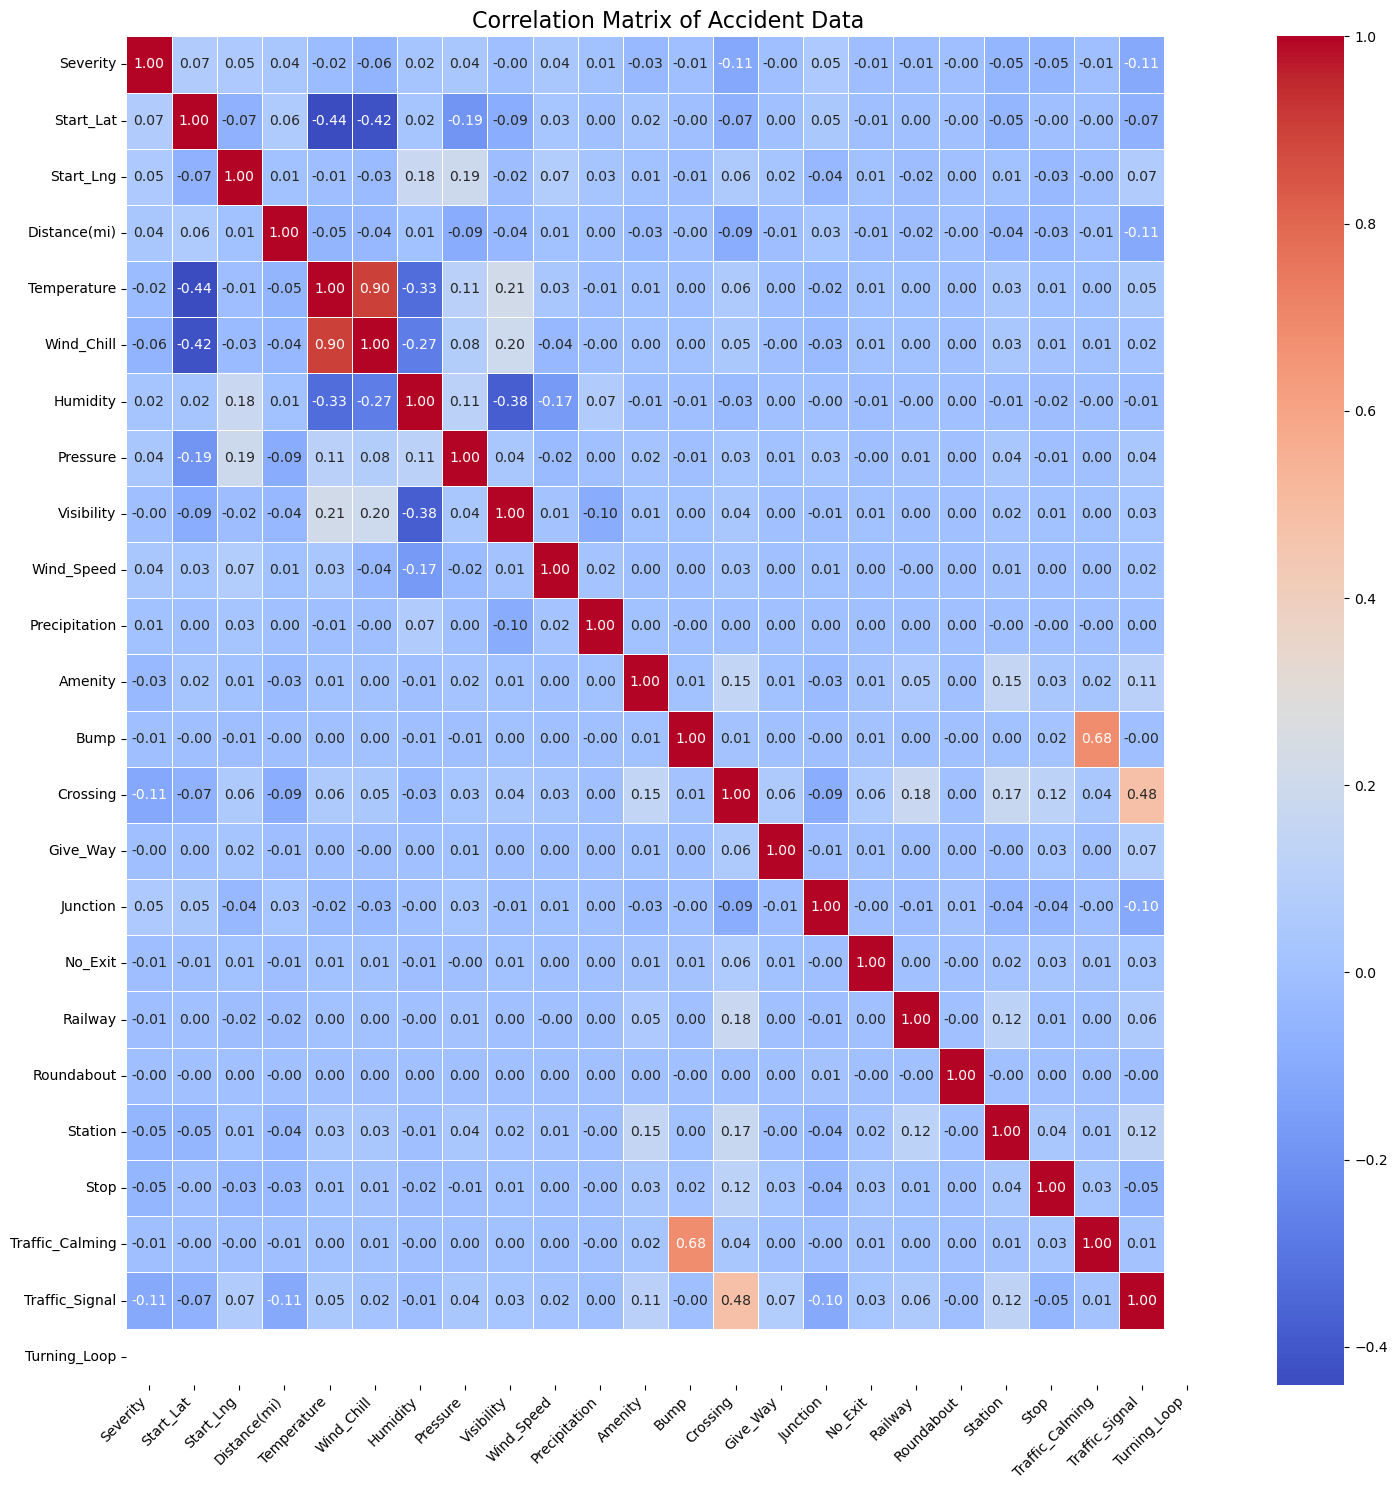

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting the heatmap
plt.figure(figsize=(15, 15))  # Making the plot larger
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Improving the aesthetics
plt.title('Correlation Matrix of Accident Data', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotating x labels for better readability
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping

# Display the plot
plt.show()


In [27]:
# Top 5 highest correlations
# Flatten the correlation matrix and sort values
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()

# Remove self-correlation pairs
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Get the top 5 highest correlations
highest_corr_pairs = corr_pairs.head(5)
print("Top 5 highest correlations:")
print(highest_corr_pairs)


Top 5 highest correlations:
Wind_Chill      Temperature       0.90
Bump            Traffic_Calming   0.68
Traffic_Signal  Crossing          0.48
Visibility      Temperature       0.21
Wind_Chill      Visibility        0.20
dtype: float64


<Figure size 1000x800 with 0 Axes>

<Axes: >

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'Temperature'),
  Text(1.5, 0, 'Traffic_Calming'),
  Text(2.5, 0, 'Crossing'),
  Text(3.5, 0, 'Visibility'),
  Text(4.5, 0, 'Wind_Chill'),
  Text(5.5, 0, 'Bump'),
  Text(6.5, 0, 'Traffic_Signal')])

Text(0.5, 1.0, 'Heatmap of Highest Correlations')

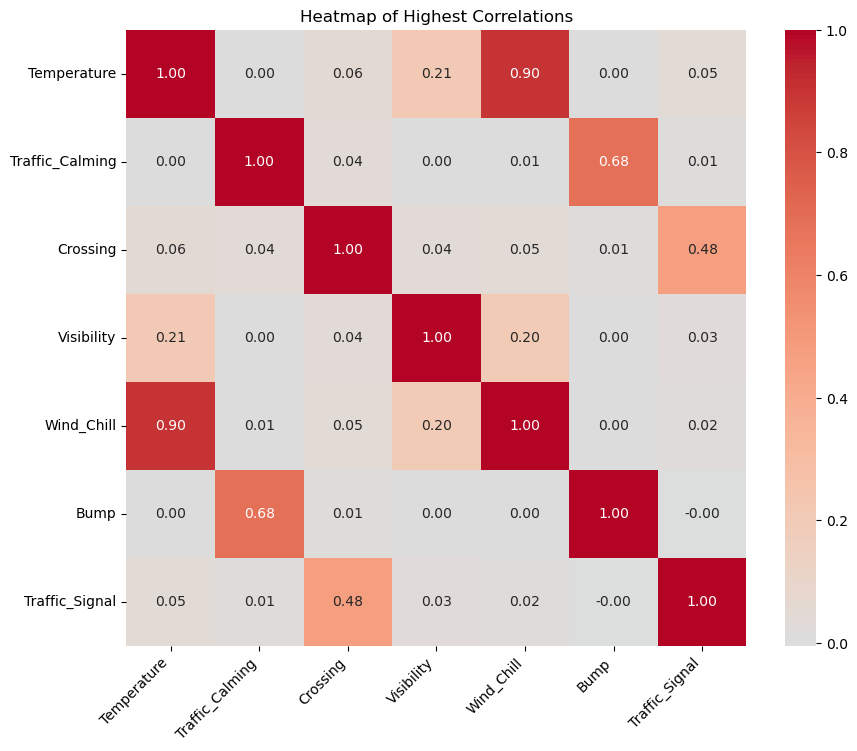

In [28]:
# Extracting the names of the columns involved in the highest correlations
highest_corr_columns = set()
for (col1, col2) in highest_corr_pairs.index:
    highest_corr_columns.add(col1)
    highest_corr_columns.add(col2)

# Creating a new DataFrame with the highest correlated columns
highest_corr_df = correlation_matrix.loc[highest_corr_columns, highest_corr_columns]

# Plotting a heatmap for the highest correlations
plt.figure(figsize=(10, 8))
sns.heatmap(highest_corr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.title('Heatmap of Highest Correlations')
plt.show()

**Temperature and Wind Chill**: There is a high positive correlation between temperature and wind chill, which is expected as they are both related to weather conditions. However, there is counterintutive finding on accidents vs weather. Most acccidents are happening at moderate temperature 50 F (rather than extreme weathers) in concenterated cities and states.

**Traffic Calming and Bump**: Traffic calming measures have a strong positive correlation with the presence of bumps. This indicates that bumps are a commonly used traffic calming measure. 

**BUMP IMPACT ON ACCIDENTS**

Bump  Number_of_Incidents
0  False              7562619
1   True                 3446

Text(0.5, 1.0, 'Impact of Bumps on Number of Incidents')

Text(0.5, 0, 'Bump Presence')

Text(0, 0.5, 'Number of Incidents')

Text(0, 7562619, '7562619')

Text(1, 3446, '3446')

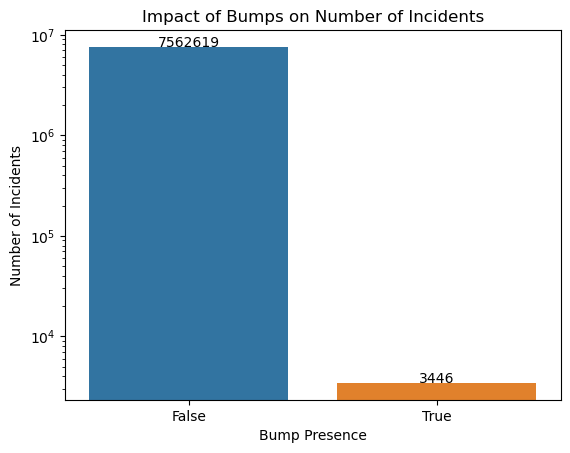

In [29]:

Bump_incident_counts = df.groupby('Bump').size().reset_index(name='Number_of_Incidents')
Bump_incident_counts
barplot=sns.barplot(x='Bump', y='Number_of_Incidents', data=Bump_incident_counts)
plt.title('Impact of Bumps on Number of Incidents')
plt.xlabel('Bump Presence')
plt.ylabel('Number of Incidents')
plt.yscale('log')
# Annotate each bar with the value
for index, row in Bump_incident_counts.iterrows():
    barplot.text(index, row.Number_of_Incidents, row.Number_of_Incidents, color='black', ha="center")
plt.show()

# Traffic Calming and Bumps: Bumps are effectively used to calm traffic. 
# The government should assess and possibly increase their use, especially near schools and residential areas.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by 'State' and 'Bump' and count the number of incidents
state_bump_counts = df.groupby(['State', 'Bump']).size().reset_index(name='Number_of_Incidents')
state_bump_counts.sort_values(by=['Number_of_Incidents'],ascending= False).head(10)


State   Bump  Number_of_Incidents
4     CA  False              1712434
13    FL  False               860487
67    TX  False               576676
62    SC  False               374995
51    NY  False               336935
40    NC  False               330052
71    VA  False               296286
59    PA  False               286779
35    MN  False               187497
57    OR  False               172814

<Figure size 1400x1000 with 0 Axes>

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'CA'),
  Text(1, 0, 'FL'),
  Text(2, 0, 'TX'),
  Text(3, 0, 'SC'),
  Text(4, 0, 'NY'),
  Text(5, 0, 'NC'),
  Text(6, 0, 'VA'),
  Text(7, 0, 'PA'),
  Text(8, 0, 'MN'),
  Text(9, 0, 'OR')])

Text(0.5, 1.0, 'Statewise Impact of Bumps on Number of Incidents')

Text(0.5, 0, 'State')

Text(0, 0.5, 'Number of Incidents')

Text(0, 1712434, 'CA: 1712434')

Text(1, 860487, 'FL: 860487')

Text(2, 576676, 'TX: 576676')

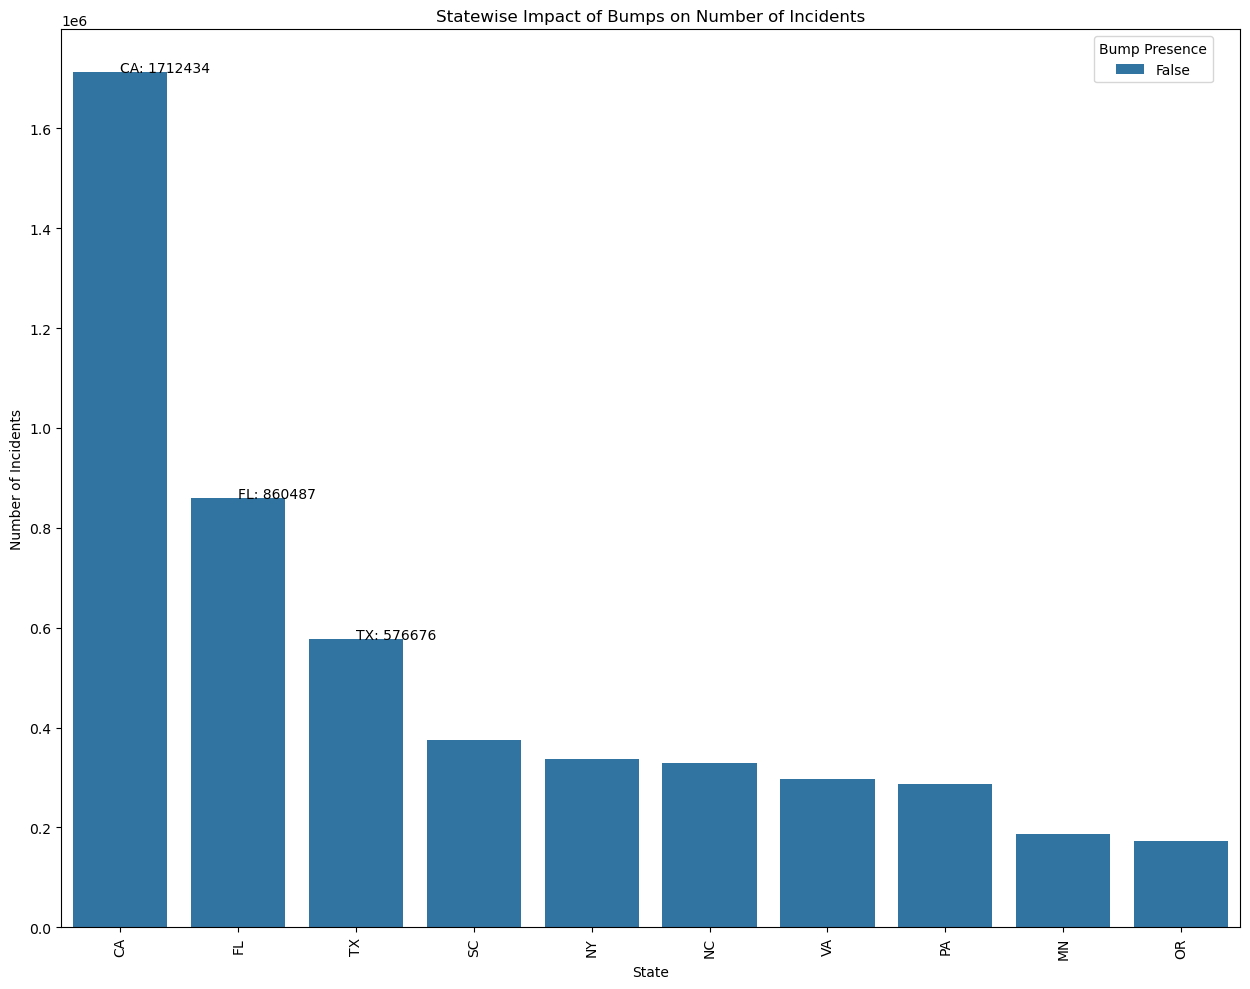

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by 'State' and 'Bump' and count the number of incidents
state_bump_counts = df.groupby(['State', 'Bump']).size().reset_index(name='Number_of_Incidents')

# Sort the results by the number of incidents, not state, to get the top incidents
state_bump_counts_sorted = state_bump_counts.sort_values('Number_of_Incidents', ascending=False).head(10)

# Plotting the results
plt.figure(figsize=(14, 10))
barplot = sns.barplot(data=state_bump_counts_sorted, x='State', y='Number_of_Incidents', hue='Bump')
plt.xticks(rotation=90)
plt.title('Statewise Impact of Bumps on Number of Incidents')
plt.xlabel('State')
plt.ylabel('Number of Incidents')
# plt.legend(title='Bump Presence')
plt.legend(title='Bump Presence', loc='upper left', bbox_to_anchor=(0.87, 1))

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make space for the legend


# Annotate the top 3 states
top_states = state_bump_counts_sorted.head(3)
for i, (index, row) in enumerate(top_states.iterrows()):
    # Get the x location of the bar
    x = i
    # Annotate with state name and incident count
    plt.text(x, row['Number_of_Incidents'], f"{row['State']}: {int(row['Number_of_Incidents'])}", color='black', ha="left")

# plt.tight_layout()
plt.show()


***Comparison number of accidents in region without and with inclusion of Signal Bumps***

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Start_Lng', ylabel='Start_Lat'>

Text(-94.71554897019267, 36.09320611161906, '1505047')

Text(-118.79911998513728, 37.07376617602641, '2317352')

Text(-82.33464905840569, 31.287618005429508, '1860112')

Text(-77.36804984356597, 40.02109976308601, '1880108')

Text(0.5, 1.0, 'Accidents Region-wise Clustering Without Bumps')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

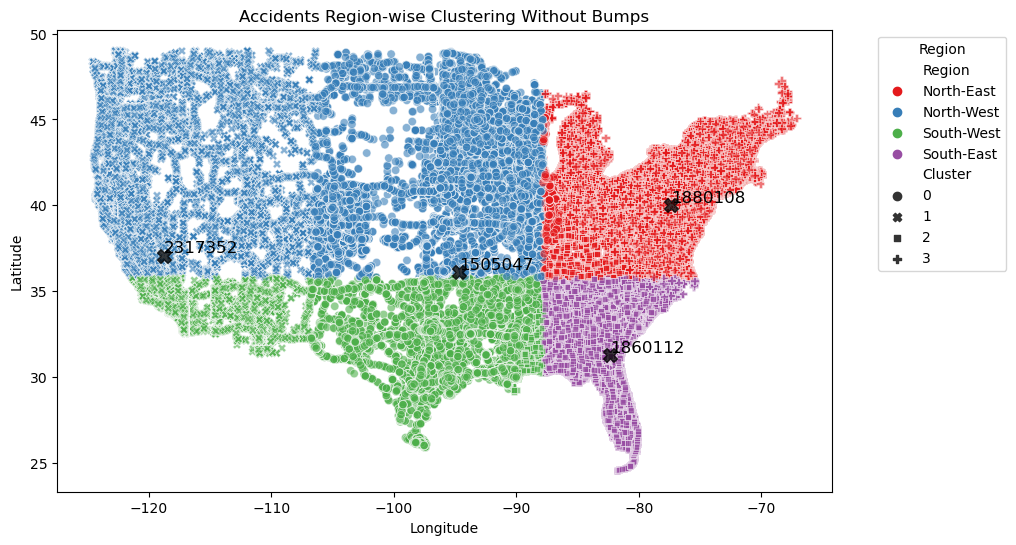

In [32]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Filter the data to include only rows with 'Bumps' being False
no_bump_data = df[df['Bump'] == False]

# Define regions based on the median values of latitude and longitude
median_lat = no_bump_data['Start_Lat'].median()
median_lng = no_bump_data['Start_Lng'].median()

# Function to determine the region based on latitude and longitude
def determine_region(lat, lng, median_lat, median_lng):
    if lat >= median_lat and lng >= median_lng:
        return 'North-East'
    elif lat < median_lat and lng >= median_lng:
        return 'South-East'
    elif lat >= median_lat and lng < median_lng:
        return 'North-West'
    else:
        return 'South-West'

# Apply the function to create a new 'Region' column
no_bump_data['Region'] = no_bump_data.apply(lambda x: determine_region(x['Start_Lat'], x['Start_Lng'], median_lat, median_lng), axis=1)

# Use KMeans to cluster the data based on 'Latitude' and 'Longitude'
kmeans = KMeans(n_clusters=4)  # We choose 4 to match the number of regions we've defined
no_bump_data['Cluster'] = kmeans.fit_predict(no_bump_data[['Start_Lat', 'Start_Lng']])

# Plotting
plt.figure(figsize=(10, 6))

# We use hue to color the data points based on the new 'Region' column
sns.scatterplot(data=no_bump_data, x='Start_Lng', y='Start_Lat', hue='Region', style='Cluster',
                palette='Set1', alpha=0.6)

# Plot the cluster centers
centers = kmeans.cluster_centers_

# Count the number of accidents per cluster
cluster_accident_counts = no_bump_data.groupby('Cluster').size()

# Annotate the cluster centers with the accident counts
for i, count in enumerate(cluster_accident_counts):
    plt.scatter(centers[i, 1], centers[i, 0], c='black', s=100, alpha=0.75, marker='X')
    plt.text(centers[i, 1], centers[i, 0], str(count), color='black', fontsize=12, ha='left', va='bottom')

plt.title('Accidents Region-wise Clustering Without Bumps')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


# The geometric center of each cluster, centriod

The cluster shows most happening without bumps. The North-East region has a dense concentration of accidents, which might correspond to an urbanized area with heavy traffic.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Start_Lng', ylabel='Start_Lat'>

Text(-78.54303910604176, 34.18849113658658, '861')

Text(-121.55398349022491, 39.17052359944347, '1310')

Text(-110.46515301034441, 33.69676629985365, '849')

Text(-96.12401114175755, 32.55234116052256, '426')

Text(0.5, 1.0, 'Accidents Region-wise Clustering with Bumps')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

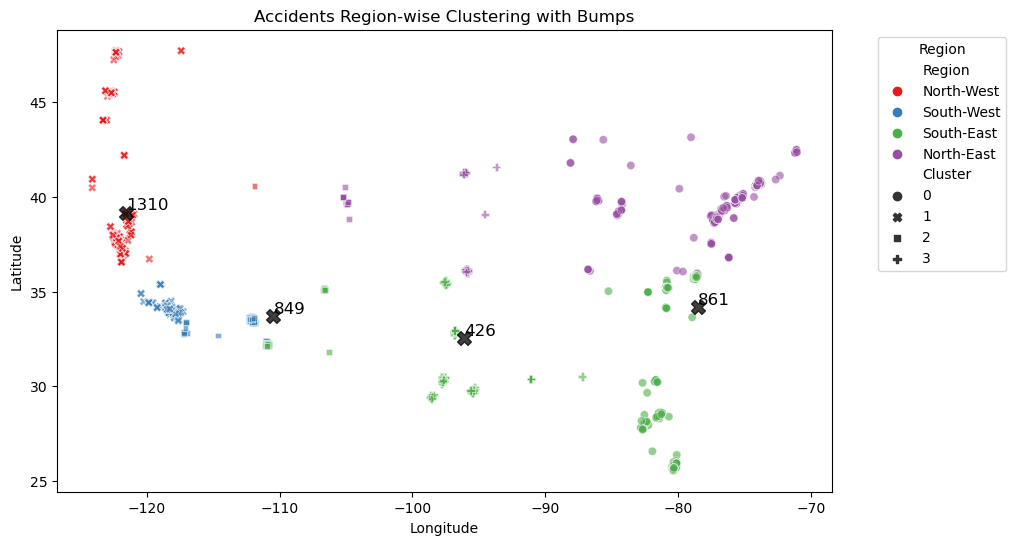

In [33]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Filter the data to include only rows with 'Bumps' being False
no_bump_data = df[df['Bump'] == True]

# Define regions based on the median values of latitude and longitude
median_lat = no_bump_data['Start_Lat'].median()
median_lng = no_bump_data['Start_Lng'].median()

# Function to determine the region based on latitude and longitude
def determine_region(lat, lng, median_lat, median_lng):
    if lat >= median_lat and lng >= median_lng:
        return 'North-East'
    elif lat < median_lat and lng >= median_lng:
        return 'South-East'
    elif lat >= median_lat and lng < median_lng:
        return 'North-West'
    else:
        return 'South-West'

# Apply the function to create a new 'Region' column
no_bump_data['Region'] = no_bump_data.apply(lambda x: determine_region(x['Start_Lat'], x['Start_Lng'], median_lat, median_lng), axis=1)

# Use KMeans to cluster the data based on 'Latitude' and 'Longitude'
kmeans = KMeans(n_clusters=4)  # We choose 4 to match the number of regions we've defined
no_bump_data['Cluster'] = kmeans.fit_predict(no_bump_data[['Start_Lat', 'Start_Lng']])

# Plotting
plt.figure(figsize=(10, 6))

# We use hue to color the data points based on the new 'Region' column
sns.scatterplot(data=no_bump_data, x='Start_Lng', y='Start_Lat', hue='Region', style='Cluster',
                palette='Set1', alpha=0.6)

# Plot the cluster centers
centers = kmeans.cluster_centers_

# Count the number of accidents per cluster
cluster_accident_counts = no_bump_data.groupby('Cluster').size()

# Annotate the cluster centers with the accident counts
for i, count in enumerate(cluster_accident_counts):
    plt.scatter(centers[i, 1], centers[i, 0], c='black', s=100, alpha=0.75, marker='X')
    plt.text(centers[i, 1], centers[i, 0], str(count), color='black', fontsize=12, ha='left', va='bottom')

plt.title('Accidents Region-wise Clustering with Bumps')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()



The cluster shows least accidents happening with inclusion of speed bumps.

**Summary of Finding:** Regions with signal bumps tend to have lower accident counts, indicating that bumps may contribute to road safety and accident prevention.

**Validity of Finding:** The clustering figure shows clear patterns where regions without and with signal bumps (represented by different clusters colors) have varying accident counts.

**Managerial Insights:** Get more bumps! The government should increase the number of signal bumps in high-accident areas could effectively reduce accident rates. Companies involved in road safety solutions could see increased demand for signal bumps and related traffic-calming products.
